In [1]:
# Change the dataset in global_vars.py to UKB.
from global_vars import *
from commons import *

import glob 
import os

one_time_n4_optimization = True
vol_to_check_list = None #['1942395_20201_2_0'] #['']
exclude = ['1004985_20201_2_0']

%load_ext autoreload
%autoreload 2

In [2]:
def load_ukb_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]

    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp**_[17s, 17sa,17sb]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in**_[17s,17sa,17sb]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F**_[17s, 17sa,17sb]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W**_[17s, 17sa,17sb]**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths

file_paths = load_ukb_file_paths()
file_paths

{'1138634_20201_2_0': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2a.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2b.nii.gz'],
   'F': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_F_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UK

In [3]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [4]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [5]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

started with 1138634_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.    

1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/3387088_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.          

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1019631_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1013250_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293   

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1584559_20201_2_0
started with 1013391_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1108214_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/5934622_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1026125_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1005379_20201_2_0
started with 5371767_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/4627690_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1036900_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1003082_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293   

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/6025746_20201_2_0
started with 5331775_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1004466_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

In [6]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 1138634_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-164.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1138634_20201_2_0
n4 processing part-2 started with 3387088_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-129.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/3387088_20201_2_0


n4 processing part-2 started with 1036900_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-166.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1036900_20201_2_0
n4 processing part-2 started with 5833278_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-169.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/5833278_20201_2_0


In [7]:
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    in_file = n4_dict[vol]['N4_2']['SCALED']
    opp_file = file_paths[vol]['ONE']['OPP']
    new_filename = opp_file.split('/')[-1].split('.')[0]
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

n4-biasfield-correction starting with 1138634_20201_2_0...
done
n4-biasfield-correction starting with 3387088_20201_2_0...
done
n4-biasfield-correction starting with 1942395_20201_2_0...
done
n4-biasfield-correction starting with 1019631_20201_2_0...
done
n4-biasfield-correction starting with 5764643_20201_2_0...
done
n4-biasfield-correction starting with 1013250_20201_2_0...
done
n4-biasfield-correction starting with 1584559_20201_2_0...
done
n4-biasfield-correction starting with 1013391_20201_2_0...
done
n4-biasfield-correction starting with 1108214_20201_2_0...
done
n4-biasfield-correction starting with 5397022_20201_2_0...
done
n4-biasfield-correction starting with 5934622_20201_2_0...
done
n4-biasfield-correction starting with 4154467_20201_2_0...
done
n4-biasfield-correction starting with 1026125_20201_2_0...
done
n4-biasfield-correction starting with 1005379_20201_2_0...
done
n4-biasfield-correction starting with 5371767_20201_2_0...
done
n4-biasfield-correction starting with 46

In [8]:
def ukb_vol_label_fix(vol, label, use_alternate_approach=False):
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affinevolume = hist_match(volume)
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
    labelmap = label.get_fdata()
    
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, sz:ez] = labelmap
    else:
        final_label[0:sx+ex, 0:sy+ey, sz-20:ez-20] = labelmap

    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    
    return vol, final_label_img

def ukb_label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape

    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print(lidx, lname)
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        sx,sy,sz,ex,ey,ez = np.abs(get_points(labelmap_img, reference_labelmap))
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
1138634_20201_2_0
['datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1138634_20201_2_0/1138634_DIXON_BH_17S_OPP_DIXON

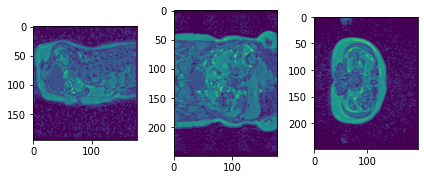

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


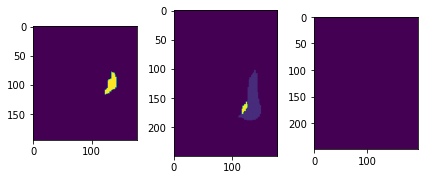

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
3387088_20201_2_0
['datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Kidney (left).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Kidney (right).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4.nii', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Spleen.nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/3387088_20201_2_0/3387088_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-15.NRRD_ADRENALGLAN

104 KIDNEY(LEFT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
101 LIVER
###############################################################################################
102 SPLEEN
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Initiating histogram match...
im dim v:  (250, 195, 178)
segm d

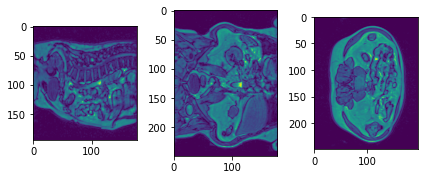

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


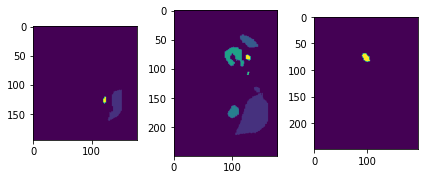

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1942395_20201_2_0
['datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp_Dixon_BH_17sa___ Spleen.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp__Dixon_BH_17sa_ Liver.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1942

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1942395_20201_2_0/1942395_DIXON_BH_17S_OPP_DIXON_BH_17SA-3.NRRD_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLM

###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Initiating histogram match...
im dim v:  (250, 195, 178)
segm dim v:  (250, 195, 121)
im spacing:  [2. 2. 3.]
segm spacing:  [2. 2. 3.]
im dim w:  [500. 390. 534.]
segm dim w:  [500. 390. 363.]
im off:  [ 247.76788  191.9643  -630.75   ]
segm off:  [ 249.99998  194.19643 -462.75   ]
im start:  [ 247.76788  191.9643  -630.75   ]
im end:  [-252.2321167  -198.03570557  -96.75      ]
segm start:  [ 249.99998  194.19643 -462.75   ]
segm end:  [-250.00001526 -195.80357361  -99.75      ]
start diff w:  [  2.2321014   2.232132  168.       ]
end_diff w  [2.23210144 2.23213196 3.        ]
start diff v:  [ 1  1 56]
end diff v:  [1 1 1]
segm end v:  [249 194 177]
segm start v:  -1 -1 56
Initiating histogram match...
Viewing Stitched Images.....
Affin

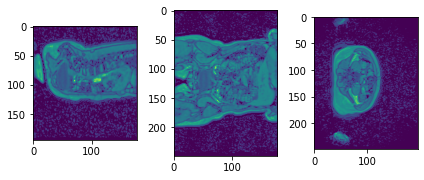

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


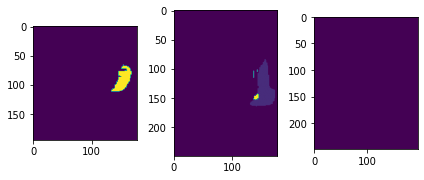

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1019631_20201_2_0
['datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_opp_17s_spleen.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1019631_20201_2_0/1019631_DIXON_BH_17S_OPP_DIXON_BH_17S.NII_GALLBLADDER.NRRD

###############################################################################################
101 LIVER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
107 PANCREAS
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Initiating histogram match...
im dim v:  (250, 195, 178)
segm dim v:  (250, 195, 

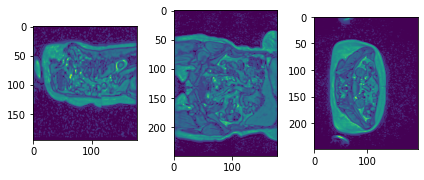

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


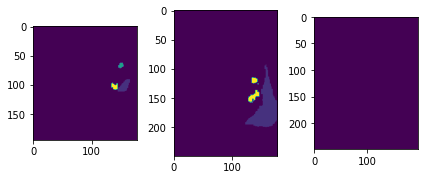

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5764643_20201_2_0
['datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMA

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/5764643_20201_2_0/5764643_DIXON_BH_17S_OPP_DIXON

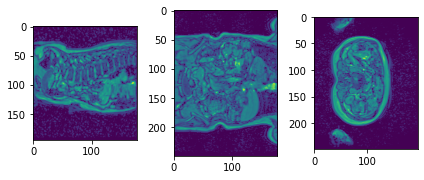

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


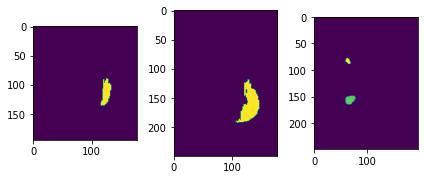

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1013250_20201_2_0
['datasets/lablmaps/UKB/1013250_20201_2_0/1013250_opp_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_20201_2_0_dixonn_BH_17s_opp_Liver-2-2.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii_Kidney (left)-2.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii_Kidney (right)-2.nrrd', 'datasets/lablmaps/UKB/1

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
SPL DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1013250_20201_2_0/1013250_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01.NII_KIDNEY(LEFT)-2.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/101325

###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 211.0
Initiating histogram match...
im dim v:  (250, 195, 178)
segm dim v:  (250, 195, 121)
im spacing:  [2. 2. 3.]
segm spacing:  [2. 2. 3.]
im dim w:  [500. 390. 534.]
segm dim w:  [500. 390. 363.]
im off:  [ 247.76788  191.9643  -630.75   ]
segm off:  [ 249.99998  194.19643 -462.75   ]
im start:  [ 247.76788  191.9643  -630.75   ]
im end:  [-252.2321167  -198.03570557  -96.75      ]
segm start:  [ 249.99998  194.19643 -462.75   ]
segm end:  [-250.00001526 -195.80357361  -99.75

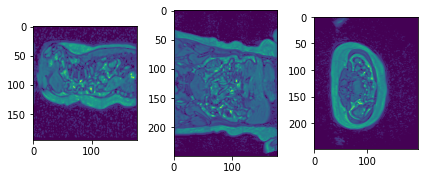

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


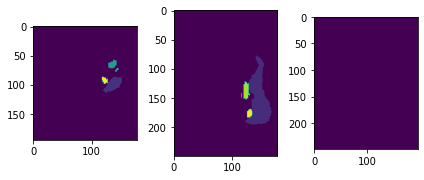

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1584559_20201_2_0
['datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Adremal gland (right)nrrd (1).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Adrenal gland(left) (1).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_20201_opp_Dixon_BH_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii.gz']
Reading Files..

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_20201_OPP_DIXON_BH_17S_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_20201_OPP_DIXON_BH_17S_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_20201_OPP_DIXON_BH_17S_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_20201_OPP_DIXON_BH_17S_SPLEEN.NRRD
[True, True] True
After 3d confirmed: (224, 174, 44)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_DIXON_BH_17S_OPP_DIXON_BH_17S-2.NRRD_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_DIXON_BH_17S_OPP_DIXON_BH_17S-2.NRRD_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_DIXON_BH_17S_OPP_DIXON_BH_17S-2.NRRD_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/UKB/1584559_20201_2_0/1584559_DIXON_BH

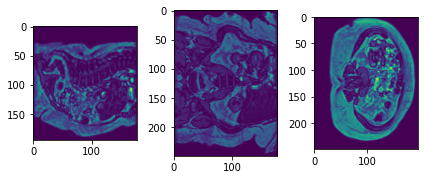

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


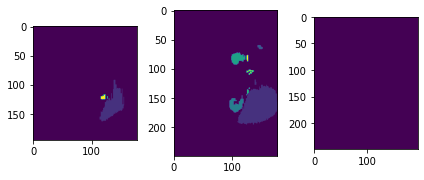

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1013391_20201_2_0
['datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Spleen.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17sa_opp_Dixon_BH_17sa.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_opp_17sa_liver-2.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17sa_opp_Dixon_BH_17sa.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17sa-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_OPP_17SA_LIVER-2.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_OPP_17SA_LIVER-2.NRRD
[True] True
After 3d confirmed: (224, 174, 44)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_DIXON_BH_17SA_OPP_DIXON_BH_17SA.NRRD_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_DIXON_BH_17SA_OPP_DIXON_BH_17SA.NRRD_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_DIXON_BH_17SA_OPP_DIXON_BH_17SA.NRRD_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_DIXON_BH_17SA_OPP_DIXON_BH_17SA.NRRD_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1013391_20201_2_0/1013391_DIXON_BH_17SA_OPP_DIXON_BH_17SA.NRRD_ADRENALGLAND(RIGHT).N

###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
101 LIVER
###############################################################################################
105 ADRENAL(RIGHT)
###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
102 SPLEEN
###############################################################################################
107 PANCREAS
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Initiating histogram match...
im dim v:  (250, 195, 178)
segm dim v:  (250, 195,

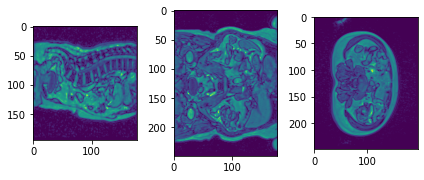

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


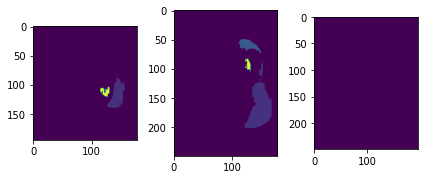

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1108214_20201_2_0
['datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Spleen.nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Pancreas.nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGR

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
SPL DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-19_PANCREAS.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1108214_20201_2_0/1108214_DIXON_BH_17S_OPP_DIXON_BH_17_

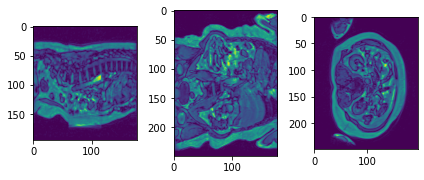

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


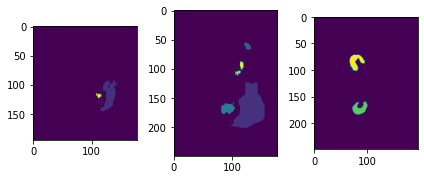

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5397022_20201_2_0
['datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nr

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/UKB/5397022_20201_2_0/5397022_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[True, True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROU

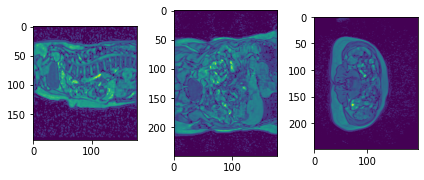

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


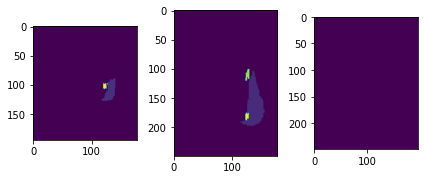

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5934622_20201_2_0
['datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/5934622_20201_2_0/5934622_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_ADRENALGLAND(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB

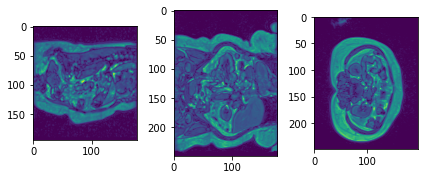

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


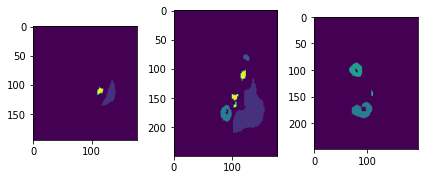

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
4154467_20201_2_0
['datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABL

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/4154467_20201_2_0/4154467_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_G

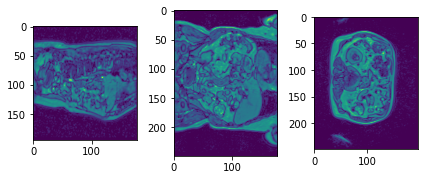

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


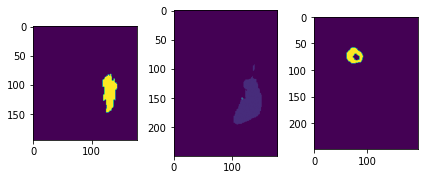

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1026125_20201_2_0
['datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Liver.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Spleen.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_co

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-20_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1026125_20201_2_0/1026125_DIXON_BH_17S

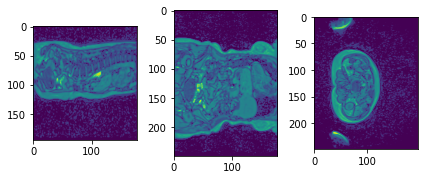

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


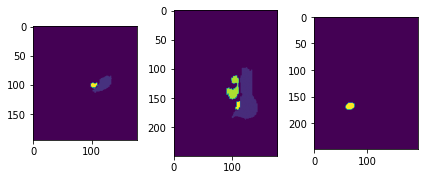

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1005379_20201_2_0
['datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_opp_17s_liver.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_opp_17s_spleen.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/ 1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s-5.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/Dixon_BH_17s_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-4_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1005379_20201_2_0/1005379_DIXON_BH

Viewing Stitched Images.....
Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


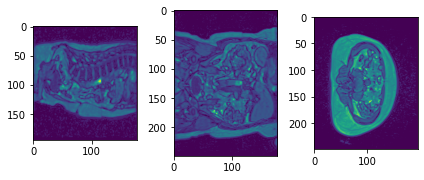

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


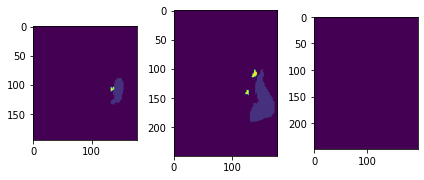

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5371767_20201_2_0
['datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd']

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
SPL DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_GALLBLADDER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/5371767_20201_2_0/5371767_DIXON_BH_17S_OPP_DIXON_BH_17_

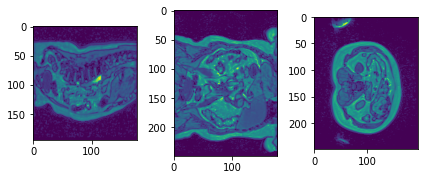

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


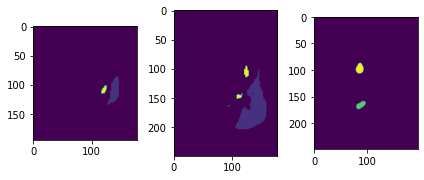

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
4627690_20201_2_0
['datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAP

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/UKB/4627690_20201_2_0/4627690_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[True, True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROU

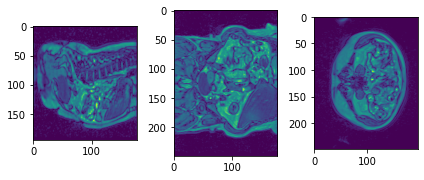

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


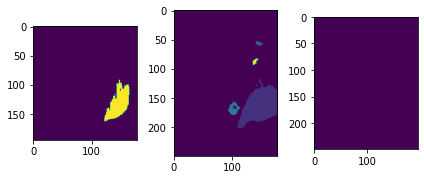

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1883132_20201_2_0
['datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Gallblader.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_20201_2_0_opp_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4Liver.nrrd', 'datasets/lablmaps/UKB/188313

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
SPL DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1883132_20201_2_0/1883132_DIXON_BH_17S_OPP_DIXON_BH_17S.NRRD_GALLBLADER.NRRD

###############################################################################################
103 KIDNEY(RIGHT)
###############################################################################################
108 GALLBLADDER
###############################################################################################
106 ADRENAL(LEFT)
###############################################################################################
101 LIVER
###############################################################################################
104 KIDNEY(LEFT)
###############################################################################################
107 PANCREAS
###############################################################################################
102 SPLEEN
###############################################################################################
Overlapped Idxs Found, removing it for idx 0.0
Overlapped Idxs Found, removing it for idx 204.0
Overlapped Idxs Found, removing i

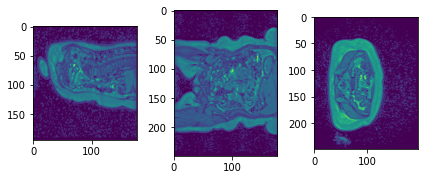

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


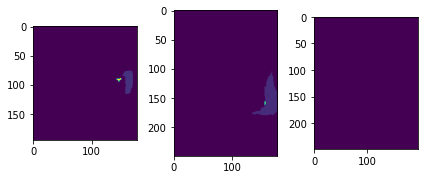

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1036900_20201_2_0
['datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Pancreas.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Spleen.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Liver.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adr

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/1036900_20201_2_0/1036900_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01-21_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1036900_20201_2_0/

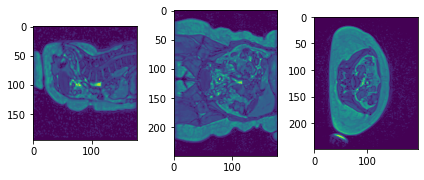

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


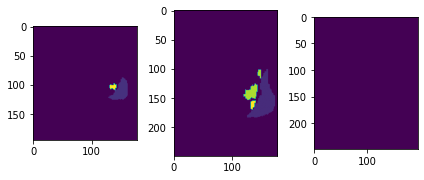

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5833278_20201_2_0
['datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd']

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(RIGHT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/5833278_20201_2_0/5833278_DIXON_BH_17S_OP

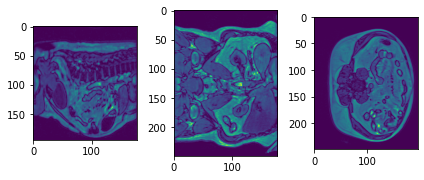

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


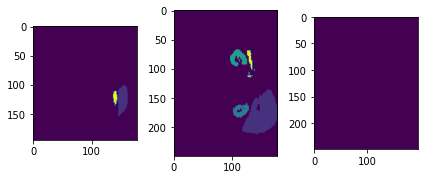

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1003082_20201_2_0
['datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Liver.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney (left)-3.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_opp_17sa_spleen.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_OPP_17SA_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_OPP_17SA_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_OPP_17SA_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_OPP_17SA_SPLEEN.NRRD
[True, True] True
After 3d confirmed: (224, 174, 44)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_DIXON_BH_17S_OPP_DIXON_BH_17SA-3_KIDNEY(RIGHT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_DIXON_BH_17S_OPP_DIXON_BH_17SA-3_KIDNEY(RIGHT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_DIXON_BH_17S_OPP_DIXON_BH_17SA-3_KIDNEY(RIGHT).NRRD
SPL DATASETS/LABLMAPS/UKB/1003082_20201_2_0/1003082_DIXON_BH_17S_OPP_DIXON_BH_17SA-3_KIDNEY(RIGHT).NRRD
[False, F

Viewing Stitched Images.....
Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


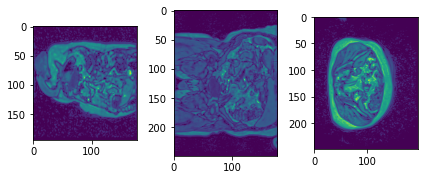

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


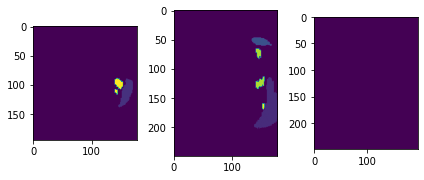

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
6025746_20201_2_0
['datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_LIVER.NRRD
[True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
SPL DATASETS/LABLMAPS/UKB/6025746_20201_2_0/6025746_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_SPLEEN.NRRD
[True, True] True
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROU

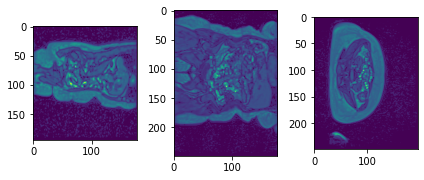

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


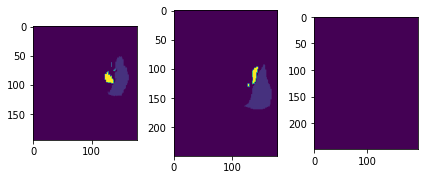

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5331775_20201_2_0
['datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd']

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON_BH_17_COMB_01_KIDNEY(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/5331775_20201_2_0/5331775_DIXON_BH_17S_OPP_DIXON

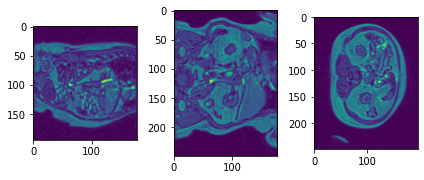

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


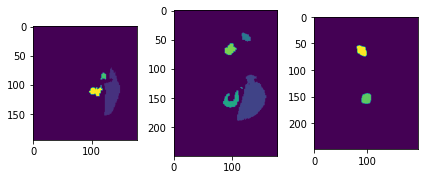

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1004466_20201_2_0
[]
#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR 1004466_20201_2_0 #########################
1002359_20201_2_0
['datasets/lablmaps/UKB/1002359_20201_2_0/1002359_opp_17sb_Spleen.nii_.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_opp_BH_17sb_combi_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_KIdney(left).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359Dixon_opp_BH_17sb.niiLiver (2)-2.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/UK

Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
BACKGROUND DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
LIVER DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
[False] False
SPLEEN DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
SPL DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
[False, False] False
KIDNEY_R DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT) DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
KIDNEY(RIGHT).NRRD DATASETS/LABLMAPS/UKB/1002359_20201_2_0/1002359_DIXON_BH_17S_OPP_DIXON_BH_17SB.NRRD_ADRENALGLAND(LEFT).NRRD
KIDNEY(RECHTS) DATASETS/LABLMAPS/UKB/1002359_20201

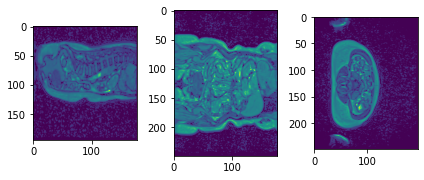

Affine:[[   2.            0.           -0.         -247.7678833 ]
 [   0.            2.           -0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


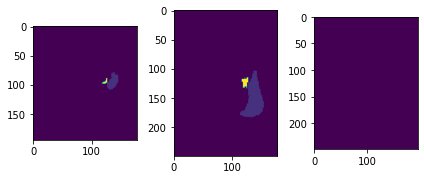

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.


In [9]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
        
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    later = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0.0)
        
        if labelname in ['SPLEEN', 'PANCREAS']:
            later.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])
        else:
            img_ras_list.append([img_ras, lidx+LABEL_EXTENSION_FOR_OVERLAP_REMOVAL, labelname])

    img_ras_list.extend(later)
        
    s_label = ukb_label_parts(img_ras_list)
    s_label = drop_overlapped_pixels(s_label, np.array(img_ras_list)[:, 1])
    
    if vol == '1004985_20201_2_0':
        volume, s_label = ukb_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = ukb_vol_label_fix(volume, s_label)

    volume = hist_match(volume)
    
    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    